# Mamba sampling for an LMM with one simple, scalar term

The simplest example of a linear mixed model (LMM) in the [lme4 package](https://github.com/lme4/lme4) package for [R](http://www.r-project.org) and the [MixedModels package](https://github.com/dmbates/MixedModels.jl) for [Julia](http://julialang.org) is a one-way classification of the yields of dyestuff in an chemical plant according to the batch of an intermediate product.

In [1]:
addprocs(4);
Pkg.update();  # the Mamba package on JuliaBox at present is old.
using Compat, Mamba

INFO: Updating METADATA...
INFO: Updating JuliaBox...
INFO: Updating Interact...
INFO: Updating Homework...
INFO: Computing changes...
INFO: No packages to install, update or remove
exception on 1: exception on ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in run_work_thunk at multi.jl:621
 in anonymous at task.jl:855
exception on 1: ERROR: opening file /home/juser/.julia/v0.3/Mamba/src/../usr/addons.jl: No such file or directory
 in open at ./iostream.jl:117
 in open at ./iostream.jl:135
 in readall at io.jl:247
 in anonymous at multi.jl:855
 in

A simple linear regression model is given in the [Mamba manual](http://mambajl.readthedocs.org/en/latest/) as

In [2]:
model = Model(
  y = Stochastic(1,
    @modelexpr(μ, σ², MvNormal(μ, √σ²)),
    false),
  μ = Logical(1,
    @modelexpr(xmat, β, xmat * β),
    false),
  β = Stochastic(1,
    :(MvNormal(2, sqrt(1000)))),
  σ² = Stochastic(
    :(InverseGamma(0.001, 0.001))
  )
);

In this formulation the sampling of `s2` is on the variance scale.

To use a Hybrid No-U-Turn and Slice sampling scheme we would set

In [27]:
scheme1 = [NUTS([:β]), Slice([:σ²], [3.0])];

A strict No-U-Turn sampling scheme would be

In [29]:
scheme2 = [NUTS([:β, :σ²])];

Alternatively, one could set user-defined samplers (because we have conjugate priors)

In [3]:
Gibbs_β = Sampler([:β],
  @modelexpr(β, σ², xmat, y,
    begin
      β_mean = mean(β.distr)
      β_invcov = invcov(β.distr)
      Σ = inv(xmat' * xmat / σ² + β_invcov)
      μ = Σ * (xmat' * y / σ² + β_invcov * β_mean)
      rand(MvNormal(μ,Σ))
    end
  )
);

In [4]:
Gibbs_σ² = Sampler([:σ²],
  @modelexpr(β, σ², xmat, y,
    begin
      a = length(y) / 2.0 + shape(σ².distr)
      b = sum((y - xmat * β).^2) / 2.0 + scale(σ².distr)
      rand(InverseGamma(a, b))
    end
  )
);

In [6]:
using Compat

Next we formulate the data

In [7]:
line = @compat Dict{Symbol,Any}(
  :x => [1, 2, 3, 4, 5],
  :y => [1, 3, 3, 3, 5]
)

Dict{Symbol,Any} with 2 entries:
  :x => [1,2,3,4,5]
  :y => [1,3,3,3,5]

In [8]:
line[:xmat] = hcat(ones(5),line[:x]);

In [11]:
srand(1234321)

In [12]:
inits = [@compat Dict{Symbol,Any}(
    :y => line[:y],
    :β => rand(Normal(0, 1), 2),
    :σ² => rand(Gamma(1, 1))) for i in 1:4]  # 3 chains

4-element Array{Dict{Symbol,Any},1}:
 [:β=>[-0.0966725,3.3424],:σ²=>2.4306662694828773,:y=>[1,3,3,3,5]]
 [:β=>[-1.17272,-2.05007],:σ²=>0.1928067815668955,:y=>[1,3,3,3,5]]
 [:β=>[-2.08457,2.85367],:σ²=>0.7336237240449138,:y=>[1,3,3,3,5]] 
 [:β=>[0.30227,-0.823113],:σ²=>2.3617521822377294,:y=>[1,3,3,3,5]]

In [47]:
scheme3 = [Gibbs_β, Gibbs_σ²];

In [13]:
setsamplers!(model,[Gibbs_β, Gibbs_σ²]);

In [14]:
draw(model)

digraph MambaModel {
	"β" [shape="ellipse"];
		"β" -> "μ";
	"σ²" [shape="ellipse"];
		"σ²" -> "y";
	"μ" [shape="diamond", fillcolor="gray85", style="filled"];
		"μ" -> "y";
	"xmat" [shape="box", fillcolor="gray85", style="filled"];
		"xmat" -> "μ";
	"y" [shape="ellipse", fillcolor="gray85", style="filled"];
}


In [15]:
sim3 = mcmc(model, line, inits, 10000, burnin=250, thin=2, chains=4);

MCMC Simulation of 10000 Iterations x 4 Chains...

	From worker 2:	Chain 1:   0% [0:15:45 of 0:15:46 remaining]
	From worker 4:	Chain 3:   0% [0:15:47 of 0:15:48 remaining]
	From worker 3:	Chain 2:   0% [0:16:24 of 0:16:25 remaining]
	From worker 5:	Chain 4:   0% [0:16:30 of 0:16:31 remaining]
	From worker 2:	Chain 1:  10% [0:00:10 of 0:00:11 remaining]
	From worker 3:	Chain 2:  10% [0:00:10 of 0:00:11 remaining]
	From worker 4:	Chain 3:  10% [0:00:10 of 0:00:11 remaining]
	From worker 2:	Chain 1:  20% [0:00:05 of 0:00:06 remaining]
	From worker 5:	Chain 4:  10% [0:00:10 of 0:00:11 remaining]
	From worker 5:	Chain 4:  20% [0:00:05 of 0:00:06 remaining]
	From worker 3:	Chain 2:  20% [0:00:05 of 0:00:06 remaining]
	From worker 4:	Chain 3:  20% [0:00:05 of 0:00:06 remaining]
	From worker 2:	Chain 1:  30% [0:00:03 of 0:00:04 remaining]
	From worker 3:	Chain 2:  30% [0:00:03 of 0:00:04 remaining]
	From worker 4:	Chain 3:  30% [0:00:03 of 0:00:04 remaining]
	From worker 2:	Chain 1:  40% [0:0

In [16]:
gelmandiag(sim3, mpsrf=true,transform=true) 

5x3 Array{Any,2}:


 ""               "PSRF"     "97.5%"
 "\u3b2[1]"      1.00071    1.00074 
 "\u3b2[2]"      1.00127    1.00134 
 "\u3c3\ub2"     1.00039    1.00094 
 "Multivariate"  1.00041  NaN       

In [17]:
gewekediag(sim3)

4x3x4 Array{Any,3}:
[:, :, 1] =
 

""             "Z-score"   "p-value"
 "\u3b2[1]"   -0.737797    0.460638  
 "\u3b2[2]"    0.453127    0.650457  
 "\u3c3\ub2"  -1.04688     0.295154  

[:, :, 2] =
 ""             "Z-score"   "p-value"
 "\u3b2[1]"   -2.41275     0.0158329 
 "\u3b2[2]"    2.64015     0.0082869 
 "\u3c3\ub2"   0.407718    0.683481  

[:, :, 3] =
 ""             "Z-score"   "p-value"
 "\u3b2[1]"    1.40407     0.160297  
 "\u3b2[2]"   -0.830801    0.406086  
 "\u3c3\ub2"  -0.266579    0.789794  

[:, :, 4] =
 ""             "Z-score"   "p-value"
 "\u3b2[1]"   -0.757544    0.448724  
 "\u3b2[2]"    1.23218     0.217881  
 "\u3c3\ub2"  -0.600322    0.548292  

In [18]:
describe(sim3)

Iterations = 252:10000
Thinning interval = 2
Chains = 1,2,3,4
Samples per chain = 4875

Empirical Posterior Estimates:
4x6 Array{Any,2}:
 ""            "Mean"    "SD"      "Naive SE"   "MCSE"          "ESS"
 "\u3b2[1]"   0.594518  1.26492   0.00905826   0.00979666  18030.2   
 "\u3b2[2]"   0.80124   0.389074  0.00278622   0.00303421  17906.2   
 "\u3c3\ub2"  1.47081   4.62364   0.0331106    0.0437897   14744.5   

Quantiles:
4x6 Array{Any,2}:
 ""             "2.5%"     "25.0%"     "50.0%"   "75.0%"   "97.5%"
 "\u3b2[1]"   -1.8796     0.00281486  0.600042  1.18989   2.98649 
 "\u3b2[2]"    0.0629085  0.626279    0.801259  0.975847  1.53399 
 "\u3c3\ub2"   0.172276   0.38817     0.673162  1.33031   7.48754 


In [19]:
hpd(sim3)

4x3 Array{Any,2}:


 ""             "2.5%"     "97.5%"
 "\u3b2[1]"   -1.79102    3.06771 
 "\u3b2[2]"    0.073973   1.53938 
 "\u3c3\ub2"   0.0889602  4.51198 

In [20]:
p = plot(sim3);

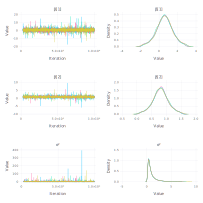

In [21]:
draw(p)